In [1]:
### %%time
import sys, os
# import pickle
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/CerebellarLoop'
path_data = f'/mnt/User_Data/UserData/eliasmfs/CerebellarLoop/SlowData/'
path_code = f'{path_gen}/Code/{year}/CerebellarLoop'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
import collections
import scipy.signal
import functools
from IPython.display import HTML, display
from tqdm import tqdm
import sklearn.metrics
import hdbscan
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 100
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['positive', 'negative']

                
seed_number_range = []     
for num in range(2,3):
    seed_number_range.append(f'Paper_all_and_eyeblink')                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 4
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
f0_range = [0,5,10,25,50,100,800]

parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02

                    "unfiltered": True, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}




Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = 0


@functools.lru_cache
def load_io_vs(coupling=True, plasticity=True, zebrin=True, n=0, f0=0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    IO_output = output_load_run('IO',
                                '_Coupled' if coupling else '',seed_number,
                                p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)
    return np.array(IO_output['Vs']/mV)


class Case(collections.abc.Mapping):
    def __init__(self, **kw):
        self.kw = kw
        for k in kw:
            assert k in ['coupling', 'zebrin', 'plasticity']
    def __len__(self):
        return 1
    def __getitem__(self, k):
        return self.kw[k]
    def __iter__(self):
        return iter(self.kw)
    def __eq__(self, other):
        for k in ['coupling', 'zebrin', 'plasticity']:
            if self.kw.get(k, '*') !=  other.kw.get(k, '*'):
                return False
        return True
    def __hash__(self):
        return __builtins__.sum(hash(f'{k}{self.kw.get(k, "*")}') for k in ['coupling', 'zebrin', 'plasticity'])
    @property
    def before(self):
        kw = dict(self.kw)
        kw['plasticity'] = False
        return Case(**kw)
    @property
    def after(self):
        kw = dict(self.kw)
        kw['plasticity'] = True
        return Case(**kw)
    @property
    def during(self):
        kw = dict(self.kw)
        kw['plasticity'] = None
        return Case(**kw)
    def __repr__(self):
        return '/'.join([
            {True: 'C', False: 'U', '*': '*'}[self.kw.get('coupling', '*')],
            {True: 'Z+', False: 'Z-', '*': '*'}[self.kw.get('zebrin', '*')],
            {True: 'AP', False: 'NP', None: 'P', '*': '*'}[self.kw.get('plasticity', '*')]])
        

CP = Case(coupling=True, zebrin=True)
CN = Case(coupling=True, zebrin=False)
UP = Case(coupling=False, zebrin=True)
UN = Case(coupling=False, zebrin=False)

def f0_name(f0):
    step = 5
    if f0 >= 50: 
        step = 25
    if f0 >= 100: 
        step = 50
    lowcut = f0
    highcut = lowcut + step
    if f0 == 800:
        lowcut = 1
        highcut = f0 
    fname = f'F{lowcut}-{highcut} Hz'
    if f0 == 0:
        fname = f'NF'
    elif f0 == 1000:
        fname = 'Steps 200'
    elif f0 == 1100:
        fname = 'Sine and original OU'
    elif f0 == 1200:
        fname = 'Sine and different filtered'
    elif f0 == 1300:
        fname = 'Sine added to OU'
    elif f0 == 1400:
        fname = 'Only sine different phases'
    elif f0 == 1500:
        fname = '5 11 53 101 199Hz sines'
    return fname

@functools.lru_cache
def load_plasticity(coupling=True, plasticity=True, zebrin=True, n=0, f0=0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    return output_load_run('mon_N_PC','_Coupled' if coupling else '',seed_number,
                           p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)['new_weight']

@functools.lru_cache
def load_noise(coupling=True, plasticity=True, zebrin=True, n=0, f0=0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    return output_load_run('Noise','_Coupled' if coupling else '',seed_number,
                           p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)['I']

@functools.lru_cache
def load_io_spikes(coupling=True, plasticity=True, zebrin=True, n=0, f0=0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    o = output_load_run('IO_spikes','_Coupled' if coupling else '',seed_number,
                           p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)

    x = []
    for i in range(N_Cells_IO):
        x.append(o[str(i)])
    return x

WARNING    <ipython-input-1-62c10a86674b>:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')
 [py.warnings]
  style.use('seaborn-colorblind')



# Figure S5-1 - A

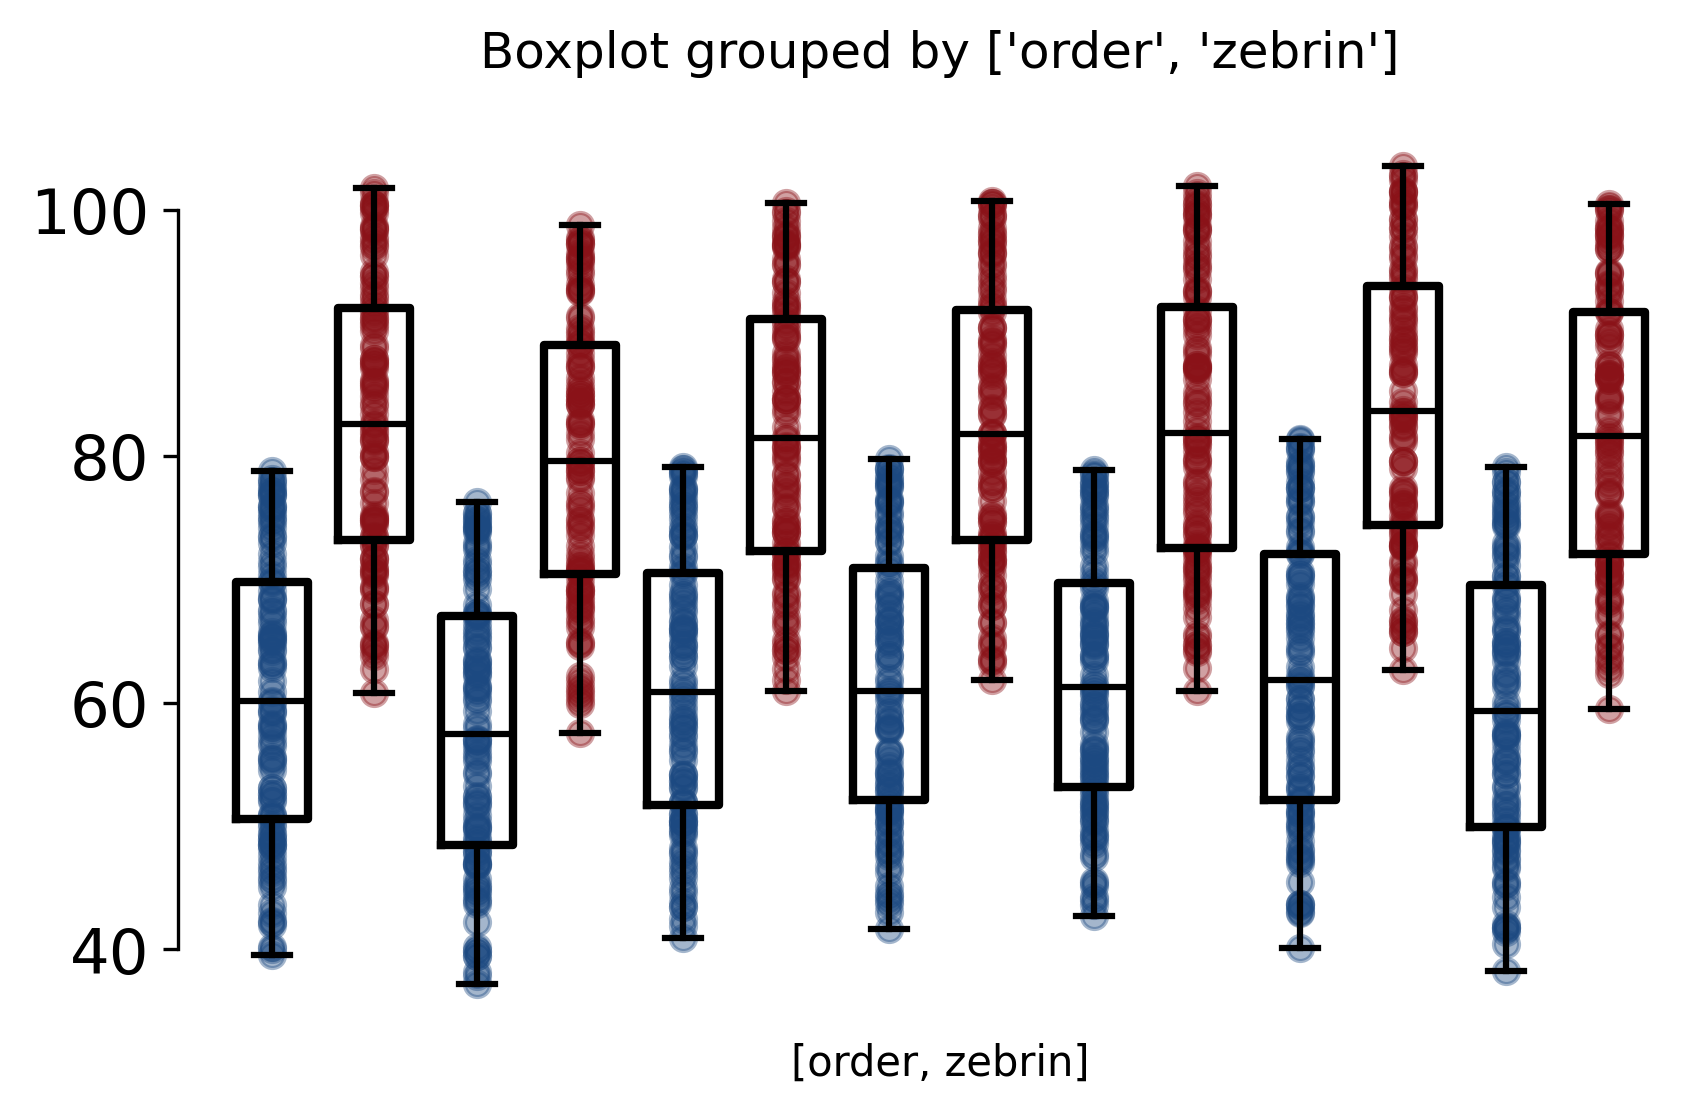

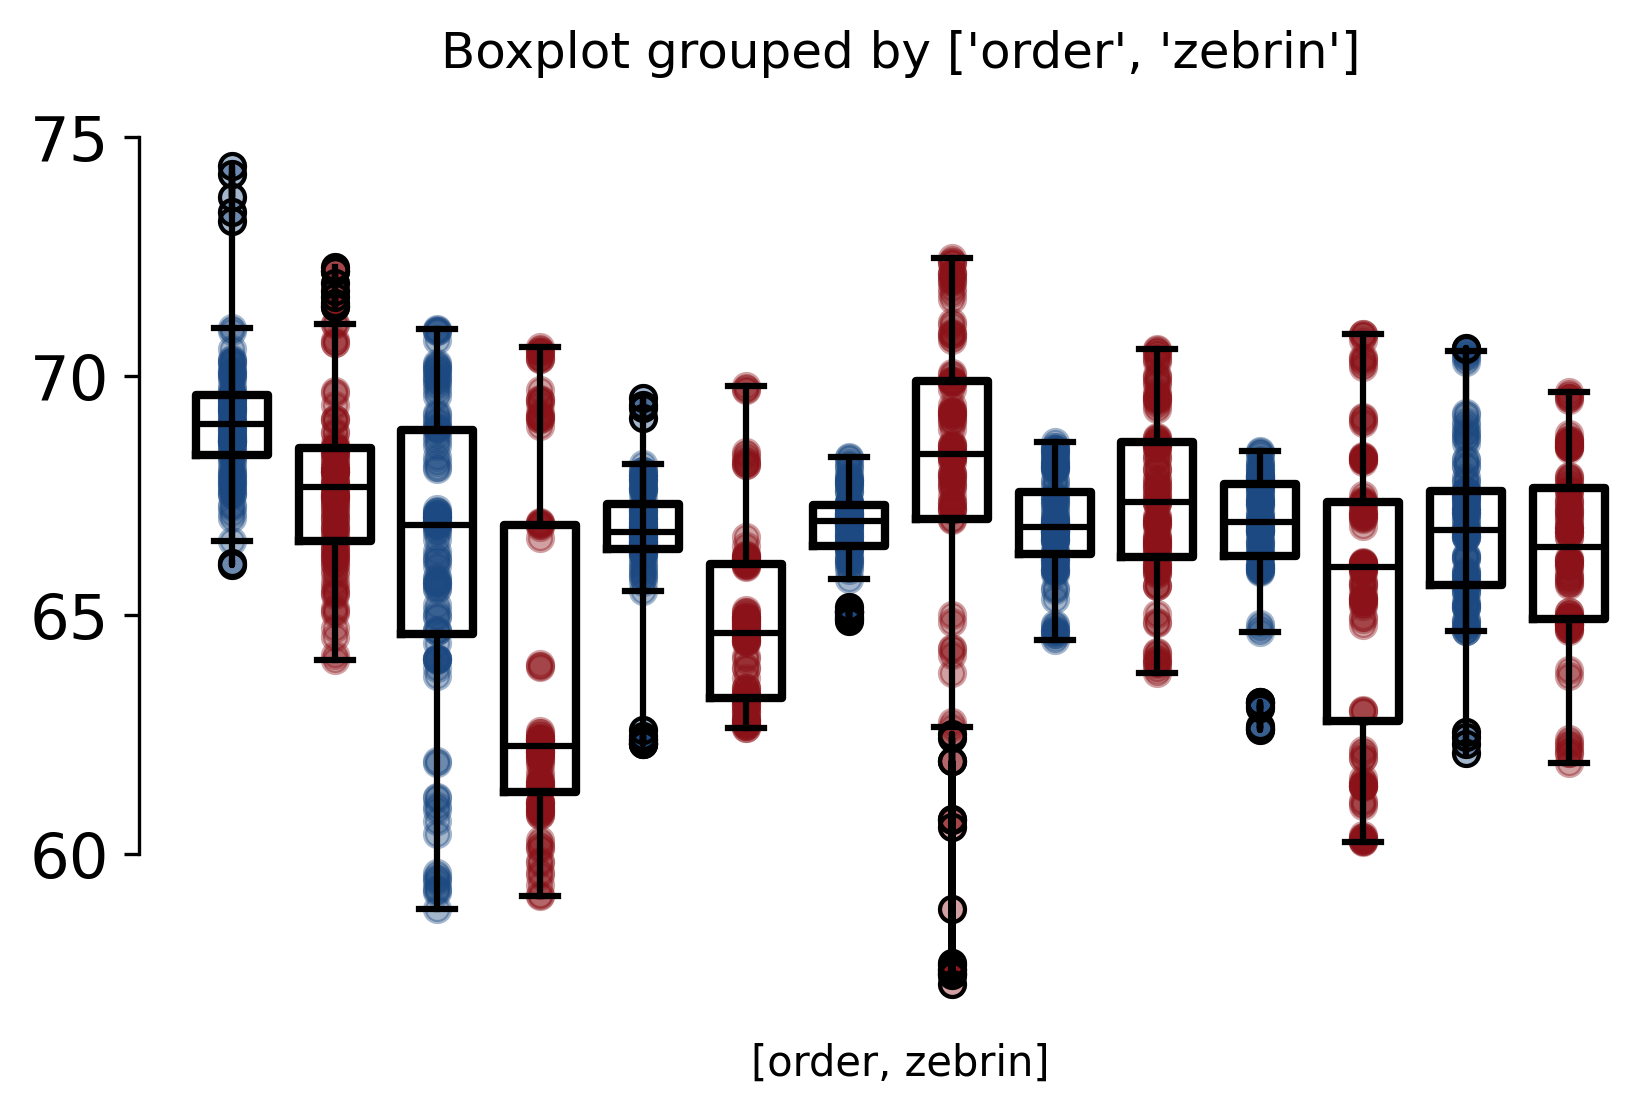

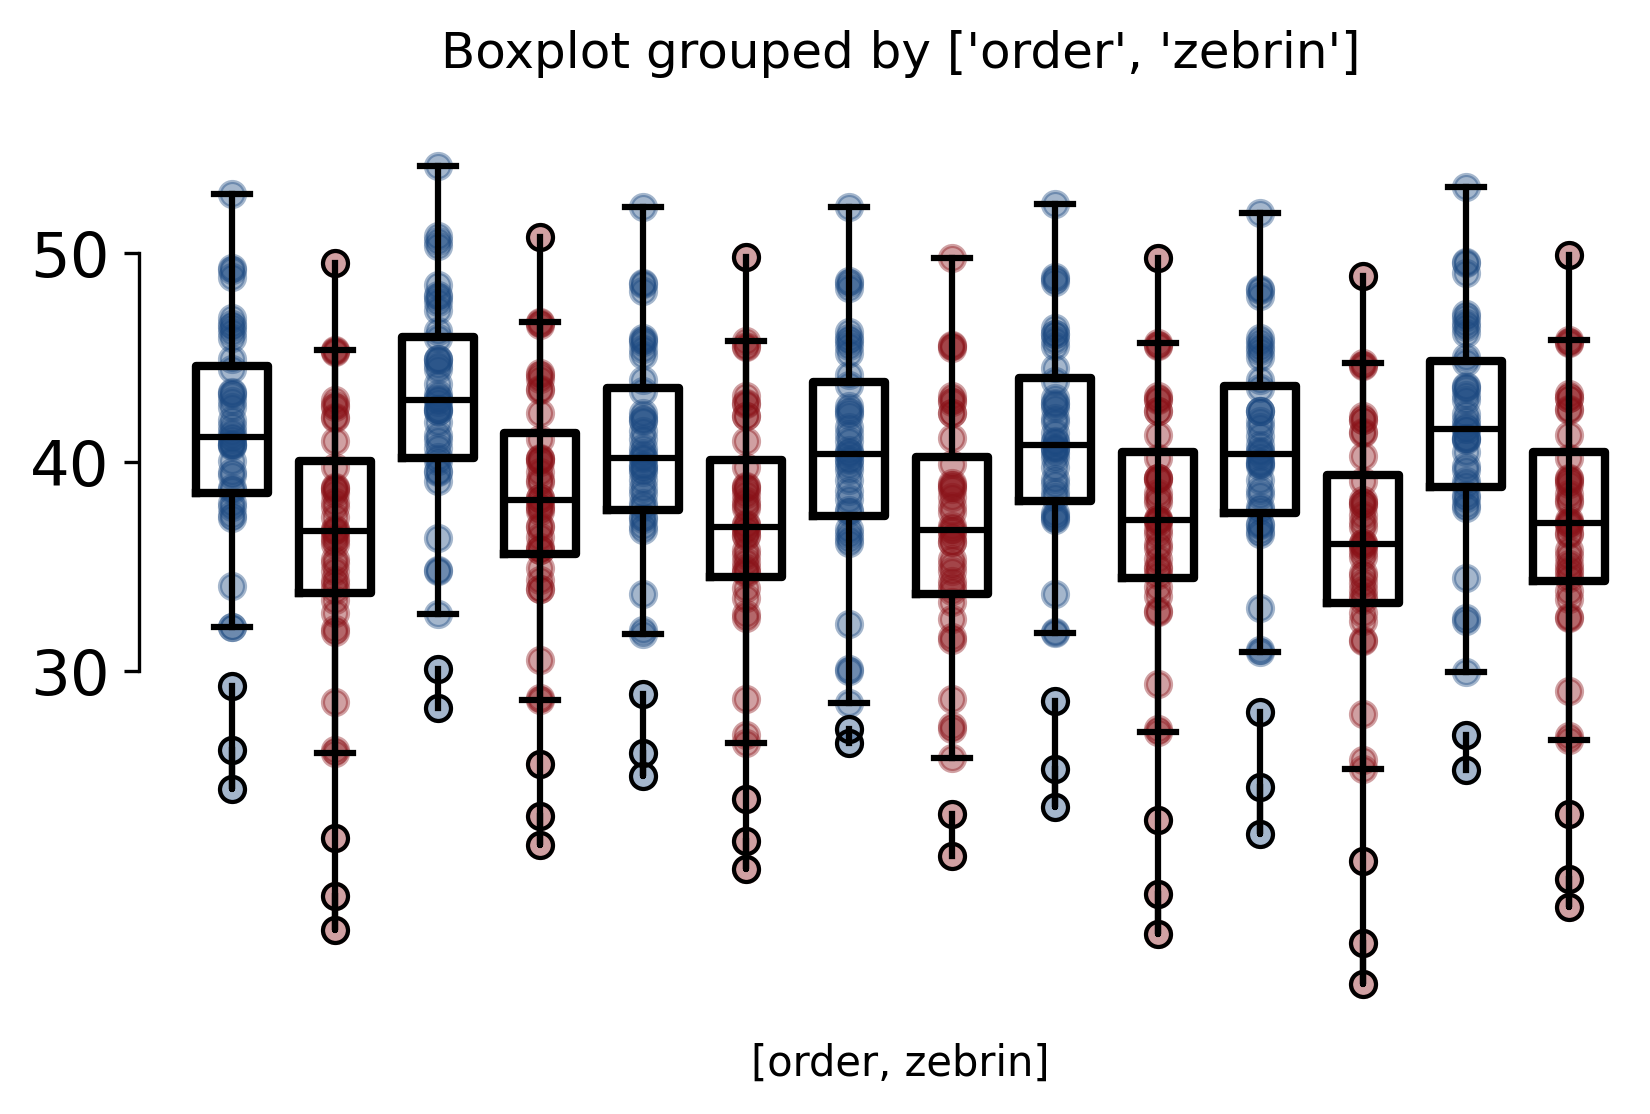

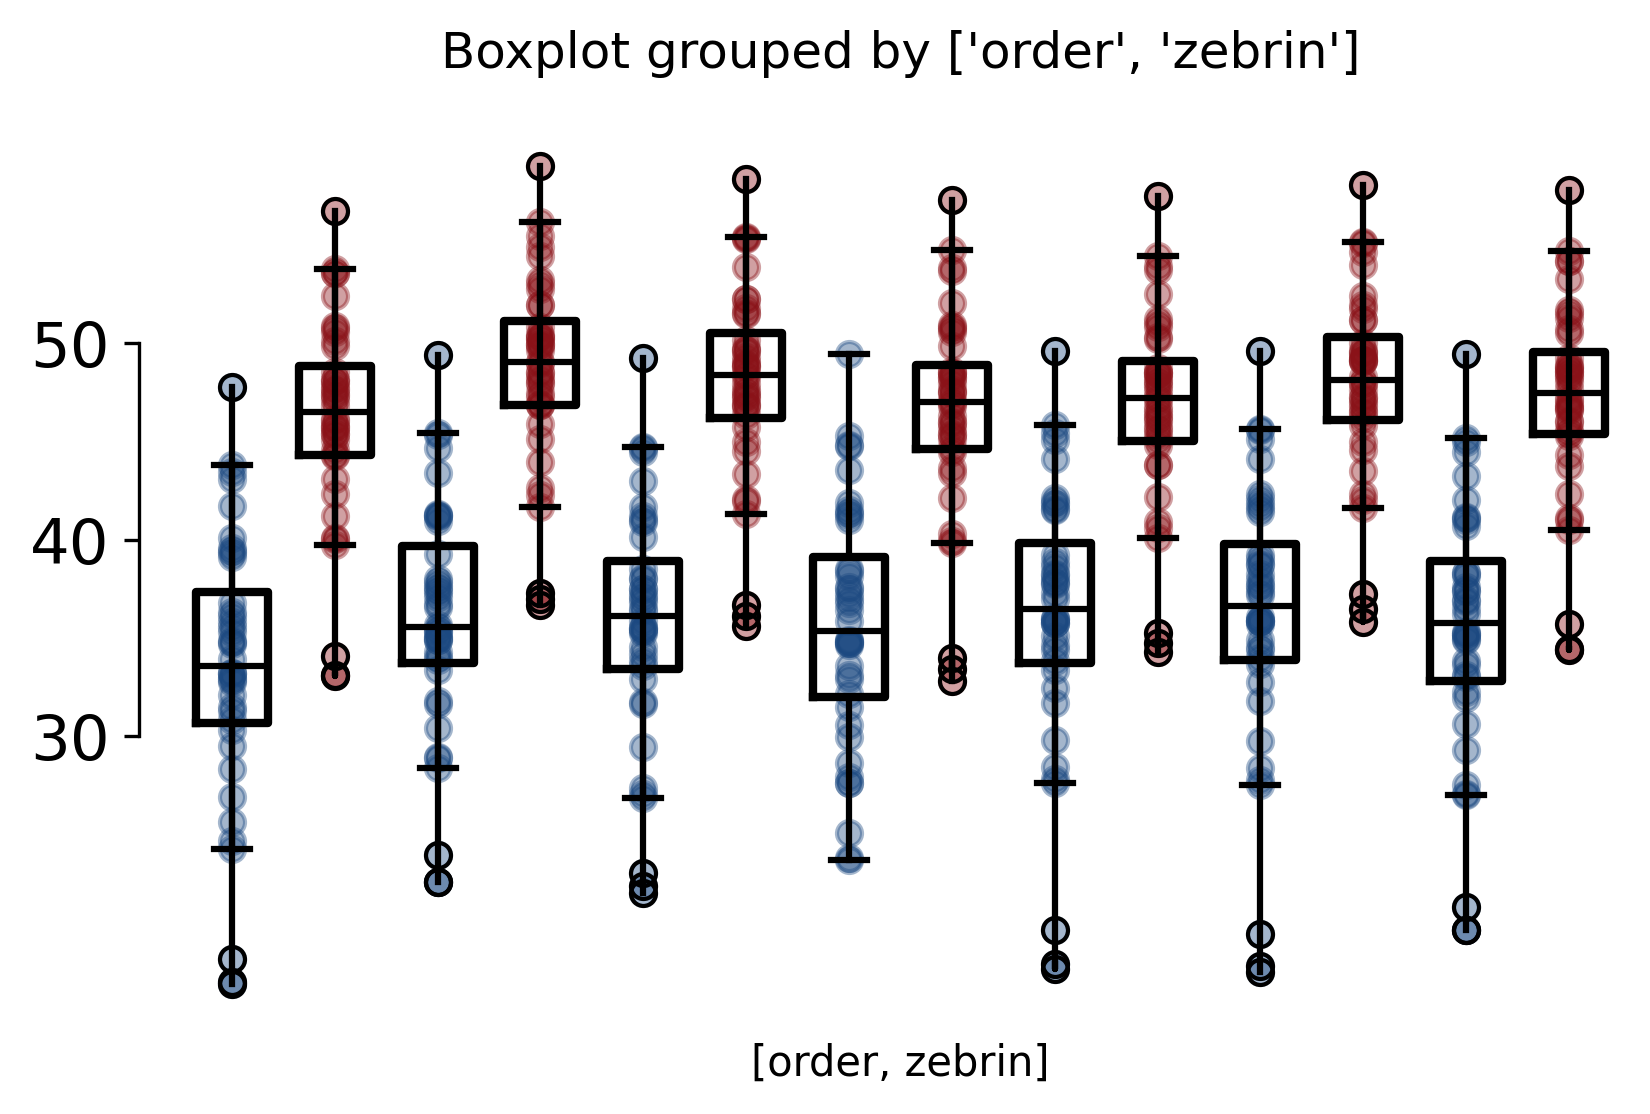

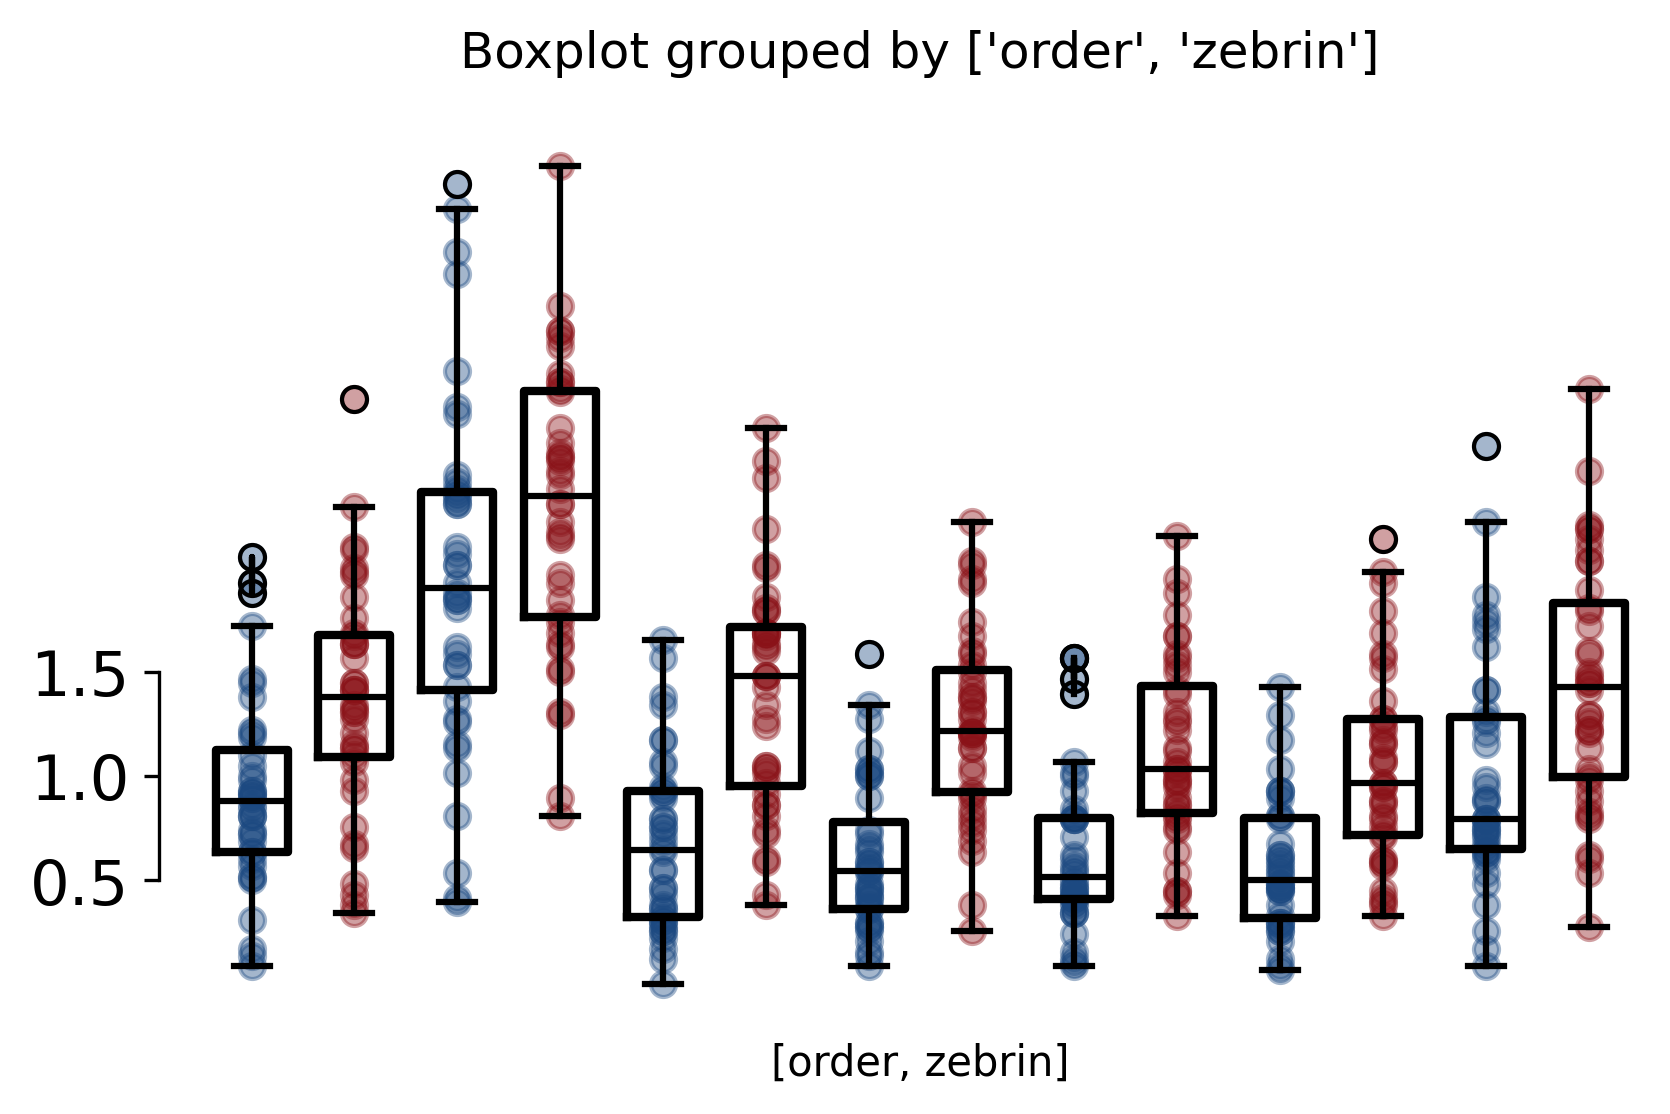

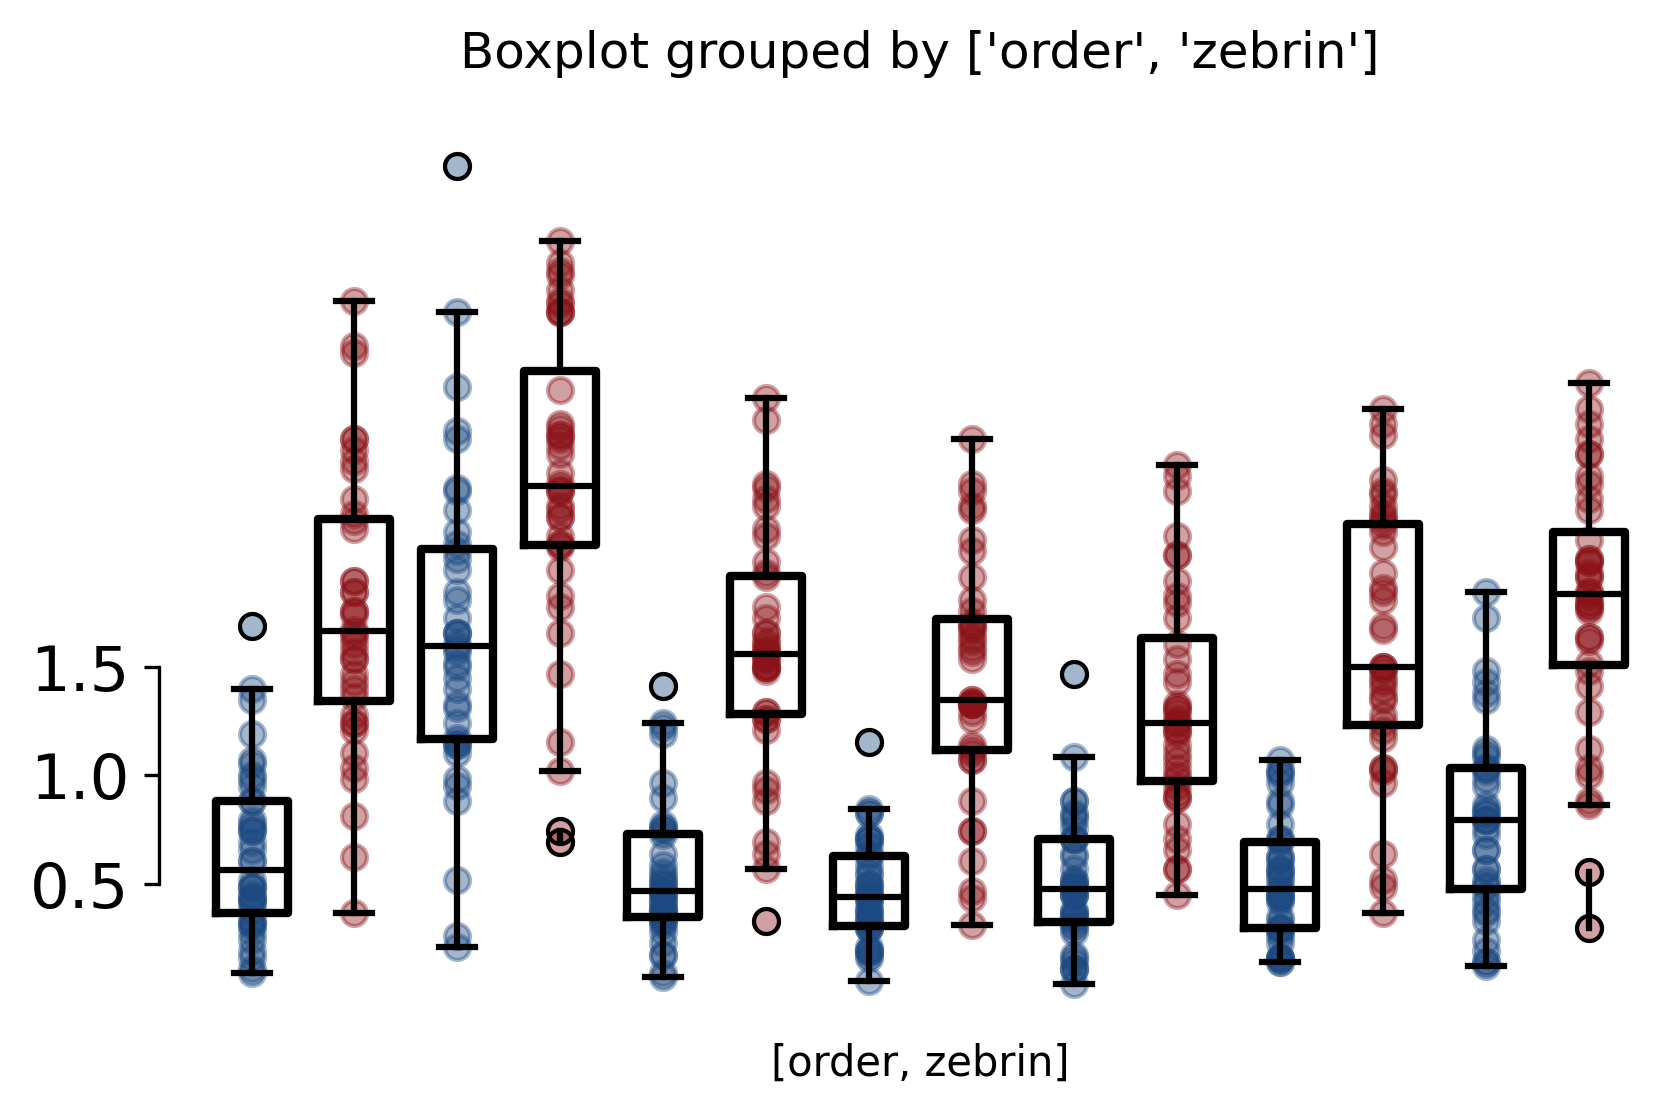

CPU times: user 3.9 s, sys: 1.18 s, total: 5.07 s
Wall time: 8.73 s


In [31]:
%%time
t_start = 1 * second
t_stop = 59 * second
bin_size = 1 * second
coupling = '_Coupled'

cmap = plt.get_cmap('Blues')
color_range=['#1c4981','#8a1218']
colors = dict(positive='#1c4981',negative='#8a1218')

zebrin_range = ['negative','positive']

names = {}
for plasticity in plasticity_range:
    if plasticity == 'no_Plasticity': names[f'{plasticity}'] = 'NP'
    elif plasticity == 'Plasticity': names[f'{plasticity}'] = 'P1'
    elif plasticity == 'Plasticity2': names[f'{plasticity}'] = 'P2'
    elif plasticity == 'Plasticity3': names[f'{plasticity}'] = 'P3'
    elif plasticity == 'Plasticity4': names[f'{plasticity}'] = 'P4'
    elif plasticity == 'after_Plasticity': names[f'{plasticity}'] = 'AP1'
    elif plasticity == 'after_Plasticity2': names[f'{plasticity}'] = 'AP2'
    elif plasticity == 'after_Plasticity3': names[f'{plasticity}'] = 'AP3'
    elif plasticity == 'after_Plasticity4': names[f'{plasticity}'] = 'AP4'

cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)

data = []
zebrin_range = ['positive','negative']
for cell_name in ['PC','DCN','IO']:
    for plasticity in ['no_Plasticity','after_Plasticity']:
        for coupling in (['', '_Coupled']):
            for zebrin in zebrin_range:
                zeb_num = 0
                if zebrin == 'negative': zeb_num = 1
                idx=0
                for f0 in f0_range:
                    spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    for cell_num in range(cell_pop_sizes[cell_name]):
                        spikes = spikes_output[f'{cell_num}']
                        bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                        spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                        mean_count = spike_counts / bin_size
                        row = dict(frequency = mean(mean_count/Hz))
                        row['cell'] = cell_name
                        row['plasticity'] = names[f'{plasticity}']
                        row['zebrin'] = zebrin
                        row['coupling'] = coupling
                        row['f0'] = f0
                        row['order'] = f'{idx}{zeb_num}'+names[f'{plasticity}']
                        data.append(row)
                    idx+=1
        df_ff = pd.DataFrame(data)
    
        df_data = df_ff[(df_ff["coupling"]==coupling) & (df_ff["cell"]==cell_name) & (df_ff["plasticity"]==names[f'{plasticity}'])]
        Q1, Q3 = percentile(df_data['frequency'],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]
        fig = plt.figure(dpi=300)
        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        bp = df_data2.boxplot(column=var, by=['order','zebrin'], grid=False, figsize=(4,3), widths=0.7, fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca())  
        title(f'')#Firing frequency {plasticity}{coupling}')
        colors = dict(positive='#1c4981',negative='#8a1218')
        for idx,f0 in enumerate(f0_range):
            for i,zebrin in enumerate(zebrin_range):
                for j,plasticity in enumerate([plasticity]):
                    y = df_data2.frequency[(df_data2.f0==f0) & (df_data2.zebrin==zebrin) & (df_data2.plasticity==names[f'{plasticity}'])].dropna()
                    x = [idx*2+1+j+(len(plasticity_range[2:3]))*i]*len(y)#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
                    scatter(x, y, color=f'{colors[zebrin]}', alpha=0.4)
                xticks([])
#         xticks(rotation=90)
        if cell_name == 'IO': yticks(np.arange(0.5, 1.5+0.1, 0.5))
        elif cell_name == 'DCN': yticks(np.arange(30, 60, 10))
        sns.despine(trim=True,bottom = True,offset = 10)
        plt.savefig(f'{cell_name}_{plasticity}_boxplot.svg')
        plt.show()

# Figure S5-1 - B

CPU times: user 6.33 s, sys: 1.43 s, total: 7.75 s
Wall time: 7.62 s


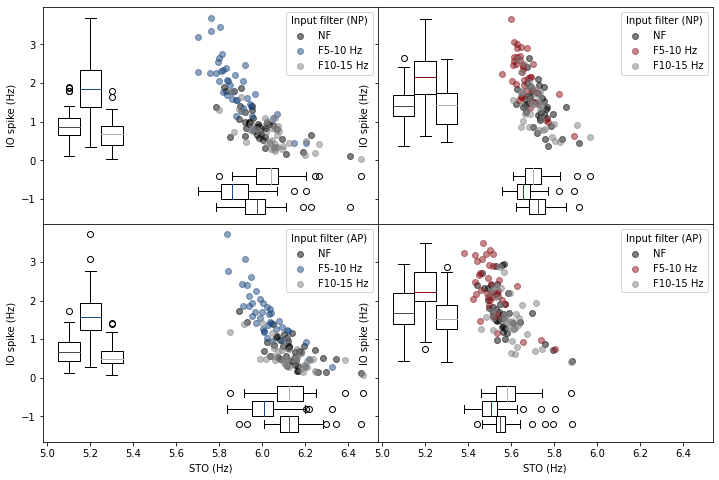

In [4]:
%%time
import sklearn.metrics


def calc_phase(vs, fs=1000, order=5, lp=4, hp=15):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.angle(analytic)
    return angle
def get_cs_freq(case, f0, n):
    cs = load_io_spikes(**case, n=n, f0=f0, noise_gain=1)
    return np.array(list(map(len, cs))) / 120
def get_sto_freq(case, f0, n):
    'taken as mean of 2nd and 3rd quartile of 1/ hilbert phase period'
    v = np.array(load_io_vs(**case, n=n, f0=f0, noise_gain=1))
    v = calc_phase(v)
    v = np.diff((v > 0).astype(int)) == 1
    def sub(x):
        x = np.sort(x)
        return x[len(x)//4:-len(x)//4]
    return np.array([np.mean(sub(1000/np.diff(np.where(vv)[0]))) for vv in v])


case = CN.after
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw=dict(hspace=0, wspace=0), sharex=True, sharey=True,
                      figsize=(12, 8))
for i in range(2):
    for j in range(2):
        if j == 0:
            case = CP
        if j == 1:
            case = CN
        if i == 0:
            case = case.before
        if i == 1:
            case = case.after
        a = ax[i, j]
        a.scatter(
            get_sto_freq(case, 0, 1),
            get_cs_freq (case, 0, 1),
            label=f0_name(0),
            alpha=0.5,
            color='black'
        )
        clr = '#8a1218' if case['zebrin'] == False else '#1c4981'
        a.scatter(
            get_sto_freq(case, 5, 1),
            get_cs_freq (case, 5, 1),
            label=f0_name(5),
            alpha=0.5,
            color=clr
        )

        a.scatter(
            get_sto_freq(case, 10, 1),
            get_cs_freq (case, 10, 1),
            label=f0_name(10),
            alpha=0.5,
            color='gray'
        )
        a.set_xlabel('STO (Hz)')
        a.set_ylabel('IO spike (Hz)')
        a.legend(title='Input filter ' + ('(NP)' if i==0 else '(AP)'))
        bp = a.boxplot(
            [get_cs_freq(case, 0, 1),
             get_cs_freq(case, 5, 1),
             get_cs_freq(case, 10, 1)],
            widths=.1,
            positions=[5.1, 5.2, 5.3],# if j == 1 else [5.5, 5.6, 5.7],
            manage_ticks=False,
        )
        bp['medians'][0].set_color('.3')
        bp['medians'][1].set_color(clr)
        bp['medians'][2].set_color('.7')
        bp = a.boxplot(
            [get_sto_freq(case, 0, 1),
             get_sto_freq(case, 5, 1),
             get_sto_freq(case, 10, 1)],
            widths=.4,
            positions=[-1.2,-0.8,-0.4],
            vert=False,
            manage_ticks=False,
        )
        bp['medians'][0].set_color('.3')
        bp['medians'][1].set_color(clr)
        bp['medians'][2].set_color('.7')
plt.savefig('svg/all4_0510.svg')

# Figure S5-1 - C

100%|██████████| 4428/4428 [00:00<00:00, 244013.80it/s]


(3835, 4000)
(3835, 4000)


100%|██████████| 6753/6753 [00:00<00:00, 243835.15it/s]


(5998, 4000)
(5998, 4000)


100%|██████████| 9103/9103 [00:00<00:00, 264976.64it/s]


(7941, 4000)
(7941, 4000)


100%|██████████| 10339/10339 [00:00<00:00, 262415.26it/s]


(8974, 4000)
(8974, 4000)


100%|██████████| 3324/3324 [00:00<00:00, 291451.34it/s]


(2824, 4000)
(2824, 4000)


100%|██████████| 6648/6648 [00:00<00:00, 241014.87it/s]


(5860, 4000)
(5860, 4000)
CPU times: user 3.76 s, sys: 12 s, total: 15.7 s
Wall time: 2min 31s


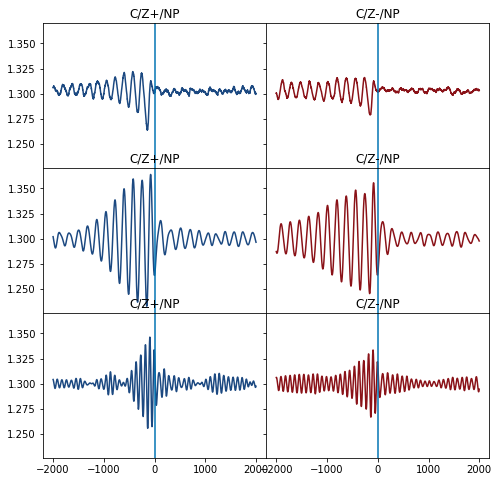

In [3]:
%%time
import tqdm
def rawPLOT_spike_triggered_vm(ax, spikes1, vm, transient_ms=10000, window_ms=500, skip=1, **k):
    spikes1 = np.concatenate(spikes1) * 1000
    #spikes1 = 1e3*np.random.random(spikes1.shape)  + spikes1
    windows = []
    for s1 in tqdm.tqdm(spikes1):
        if np.random.random() > skip:
            continue
        if s1 - window_ms < transient_ms or s1 + window_ms > 120000:
            continue
        v = vm[int(round(s1 - window_ms)):int(round(s1 + window_ms))]
        if v.shape[0] != window_ms*2:
            continue
        windows.append(v)#.mean(0))
    w = np.stack(windows)
    print(w.shape)
    x = np.arange(-window_ms, +window_ms)
    print(w.shape)
    ax.plot(x, w.mean(0), **k)

fig, ax = plt.subplots(ncols=2,nrows=3, gridspec_kw=dict(hspace=0, wspace=0), sharex=True, sharey=True,
                      figsize=(8, 8), )
for iii, f0 in enumerate([0, 5, 10]):
    for i in range(1):
        for j in range(2):
            if j == 0:
                case = CP
            if j == 1:
                case = CN
            if i == 0:
                case = case.before
            if i == 1:
                case = case.after
            #ai = ax[i,j]
            ai = ax[iii, j]
            ai.set_title(repr(case))
            ii = load_noise(**case, f0=f0)
            w = load_plasticity(**case, f0=f0).reshape(100, 5, -1)
            psc = (ii[None,:,:] * w).mean(0)
            psc = psc.mean(0)
            #psc = ii.mean(0)[None,:]
            #psc = load_io_vs(**case, f0=f0)
            rawPLOT_spike_triggered_vm(
                ai,
                load_io_spikes(**case, f0=f0),
                psc*1e9,
                window_ms=2000,
                color = '#8a1218' if j == 1 else '#1c4981'
            )
            ai.axvline(0)
            #plt.ylim(-70, -40)
# plt.savefig('svg/input_sig_0_5_10.svg')